# Предсказание активности пользователей услуг добровольного медицинского страхования
**Заказчик**: [MAINS Lab](https://mainslab.ai/)

*Жуков Игорь, Москва, 2024 г.*   [@Igor_A_Zhukov](https://t.me/Igor_A_Zhukov)

# Описание задачи

- Доступны данные о количестве обращений за медицинской помощью по 50 000 застрахованным ДМС за 2022 год. 

Доступны 2 выборки: 

- `train` - выборка для обучения и валидации, 50 тыс. застрахованных с проставленными значениями `target`.
- `holdout` - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения `target` скрыты.

Для оценки качества модели будет применяться метрика `MSE`.

**Задача:**
- На основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 


**Что должно быть в результате:**

- Рабочий ноутбук или файл .py, содержащий:
    - Код предобработки данных
    - Код обучения модели
    - Код тестирования модели
- Файл .csv с предсказаниями на выборке `holdout` с указанием `id` застрахованного и предсказанием модели
- Список использованных признаков с указанием их значимости
- Комментарии по ходу выполнения задачи

**Описание исходных данных**

- `Insured_PIN` - уникальный ид застрахованного лица
- `Insured_Network` - Идентификатор сети клиник доступной для застрахованного. Network - 1 - клиники с наивысшим уровнем сервиса, Network - 8 - клиники с самым базовым уровнем сервиса.
- `Nationality` - национальность застрахованного.
- `Gender` - пол застрахованного
- `Relation` - в качестве кого застраховано данное лицо. self - работник организации, которая оформляет страховку, child - ребенок застрахованного и т.д.
- `DoB` - дата рождения застрахованного
- `Diagnoses` - все диагнозы застрахованного за 2022 год
- `HasChronicDisease` - флаг хронического пациента
- `Exposition_22` - количество дней в 2022 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2022 год
- `number_of_visits_22` - количество дней в 2022 году в которые застрахованный посещал клинику для получения медицинской помощи
- `number_of_services_22` - количество оказанных медицинских услуг в 2022 году (консультации, анализы, лекарства и т.д.)
- `Exposition_23` - количество дней в 2023 году в которые у данного застрахованного действовал полис медицинского страхования. Значение 365 говорит о том, что застрахованный мог обращаться за медицинской помощью весь 2023 год
- **`Target`** - `number_of_visits_23` - количество дней в 2023 году в которые застрахованный посещал клинику для получения медицинской помощи

# План действий:

- загрузка данных
- первичный анализ данных
- изучение аномалий и пропусков, принятие решений о способах обработки
---

- разделение выборки на `обучающую` и `проверочную`
- создание синтетических признаков, создание датасета для исследовательского анализа
---
- изучение распределения количественных признаков и поиск выбросов
- изучение корреляции
- изучение мультиколлинеарности
---

- построение пайплайна для линейной модели:
    - предварительная обработка данных, создание признаков
    - настройка с использованием кросс-валидации.
    
- построение пайплайна для градиентной линейной модели:
    - предварительная обработка данных, создание признаков
    - подбор гиперпараметров с использованием кросс-валидации.

- построение пайплайна для классической ансамблевой модели:
    - предварительная обработка данных, создание признаков
    - подбор гиперпараметров с использованием кросс-валидации.

- построение пайплайна для ансамблевой модели с использованием градиентного бустинга:
    - предварительная обработка данных, создание признаков
    - подбор гиперпараметров с использованием кросс-валидации.
---
    
- сравнение метрик моделей
- выбор модели
- изучение важности признаков для лучшей модели
---

- проверка качества прогнозирования лучшей модели на `проверочной` выборке
- проверка модели на адекватность на `проверочной` выборке
---
- обучение лучшей модели на полной `обучающей` выборке
- создание прогноза на `тестовой` выборке
---
- отчет и рекомендации

## Загрузим необходимые библиотеки и осуществим настройки вывода

### Загрузим библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



from sklearn.preprocessing import (OneHotEncoder,
                                   OrdinalEncoder,
                                   StandardScaler,
                                   RobustScaler)

from sklearn.compose import ColumnTransformer

from sklearn.base import (BaseEstimator, 
                          TransformerMixin)

from sklearn.pipeline import Pipeline

from sklearn.model_selection import (train_test_split,
                                     GridSearchCV)

from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             r2_score)

from sklearn.linear_model import (LinearRegression, 
                                  SGDRegressor)
from sklearn.ensemble import RandomForestRegressor

from sklearn.dummy import DummyRegressor

from catboost import CatBoostRegressor

from optuna.integration import OptunaSearchCV
from optuna.distributions import (CategoricalDistribution,
                                  FloatDistribution,
                                  IntDistribution)

import re
import os
import phik
import joblib
import shap

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

### Определим значения констант

In [3]:
RANDOM_STATE = 53
TEST_SIZE = 0.2

## Загрузим и изучим данные

### Объявим функцию загрузки
с проверкой загрузки, заданием индекса и приведением наименований столбцов к общепринятому виду

In [4]:
def loader(path):
    
    '''Функция загружает файл по указанному пути и приводит заголовки к стандартному виду
Аргумент path должен принять путь к файлу, включая имя файла'''
    
    loaded_data=[]
    if os.path.exists(path):
        loaded_data = pd.read_excel(path, index_col=[0])
        print('Загружен файл: ', path)
        loaded_data.columns = [re.sub(r'(?<!^)(?=[A-Z])',
                '_', i).lower() for i in loaded_data.columns]
    else:
        print('Проверьте путь')

    return loaded_data

#### Загрузим данные

In [5]:
path1 = 'ML_train.xlsx'
path2 = 'ML_holdout.xlsx'

In [6]:
data = loader(path1)
holdout = loader(path2)

Загружен файл:  ML_train.xlsx
Загружен файл:  ML_holdout.xlsx


### Объявим функцию description для первичного исследования данных

In [7]:
def description(data):

    '''Функция принимает на входе датасет и выводит для исследуемого датасета:
    - описание info(),
    - первые две и последние две строки,
    - количество полных дубликатов,
    - количество пропущенных значений,
    - количество уникальных индексов,
    - статистические характеристики датасета,
    - первые 5 и последние 5 уникальных элементов каждого столбца
    '''
    print('\033[1m \nОбщая информация: \n\033[0m \n')
    data.info()
    display(data.head(2))
    display(data.tail(2))

    print('\n\033[1m Количество дубликатов: \033[0m', data.duplicated().sum())
    print('\033[1m Пропущенных значений: \033[0m', data.isna().sum().sum())
    print('\033[1m Уникальных индексов: \033[0m', data.index.nunique())
    print('\n\033[1m  Статистические характеристики датасета: \033[0m')

    display(data.describe(include = 'all', datetime_is_numeric=True).T)

    print('\033[1m \nИзучим 5 минимальных и 5 максимальных значений каждого столбца: \033[0m \n')
    for column in data.columns:
        try:
            print(column, 'Уникальных значений:', data[column].nunique())
            print(sorted(data[data[column].notna()][column].unique())[0:5], '.....',
                  sorted(data[data[column].notna()][column].unique())[-5:-1],
                  sorted(data[data[column].notna()][column].unique())[-1], '\n')
        except:
            print('не может быть показана - пропуски или ошибка')


## Изучим имеющиеся данные

### Изучим датасет `data`

In [8]:
description(data)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 1006786 to 9952098
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   insured__network       50000 non-null  object        
 1   nationality            50000 non-null  object        
 2   gender                 50000 non-null  object        
 3   relation               50000 non-null  object        
 4   do_b                   49999 non-null  datetime64[ns]
 5   diagnoses              41226 non-null  object        
 6   has_chronic_disease    50000 non-null  int64         
 7   exposition_22          50000 non-null  int64         
 8   number_of_visits_22    50000 non-null  int64         
 9   number_of_services_22  50000 non-null  int64         
 10  exposition_23          50000 non-null  int64         
 11  number_of_visits_23    50000 non-null  int64         
dtypes: datetime64[ns](1), int64(

,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,number_of_visits_23
Insured_PIN,,,,,,,,,,,,
1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365,0
1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365,4


,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,number_of_visits_23
Insured_PIN,,,,,,,,,,,,
9950431,Network-1,Group 4,Male,Self,1966-08-13,R69;N39.0;I10;J02.9;E78.0;J02;E11;E55.9;E09.21;J20;E79.0;J45.9;J06,1,365,14,56,365,10
9952098,Network-1,Group 4,Female,Child,2008-01-12,J06,0,365,1,5,365,0



 Количество дубликатов:  2220
 Пропущенных значений:  8775
 Уникальных индексов:  50000

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
insured__network,50000,8,Network-2,46557,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nationality,50000,6,Saudi,46696,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,50000,2,Male,25584,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relation,50000,5,Self,21839,NaN,NaN,NaN,NaN,NaN,NaN,NaN
do_b,49999,NaN,NaN,NaN,1990-02-22 19:50:30.036600704,1920-03-21 00:00:00,1971-03-23 00:00:00,1991-11-13 00:00:00,2011-04-17 00:00:00,2022-11-12 00:00:00,NaN
diagnoses,41226,35466,J06.9,332,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_chronic_disease,50000.0,NaN,NaN,NaN,0.33794,0.0,0.0,0.0,1.0,1.0,0.473013
exposition_22,50000.0,NaN,NaN,NaN,358.89896,50.0,365.0,365.0,365.0,365.0,35.562003
number_of_visits_22,50000.0,NaN,NaN,NaN,5.74032,0.0,1.0,4.0,8.0,151.0,6.592556
number_of_services_22,50000.0,NaN,NaN,NaN,22.47742,0.0,3.0,13.0,31.0,962.0,29.714146


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

insured__network Уникальных значений: 8
['Network-1', 'Network-2', 'Network-3', 'Network-4', 'Network-5'] ..... ['Network-4', 'Network-5', 'Network-6', 'Network-7'] Network-8 

nationality Уникальных значений: 6
['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Others'] ..... ['Group 2', 'Group 3', 'Group 4', 'Others'] Saudi 

gender Уникальных значений: 2
['Female', 'Male'] ..... ['Female'] Male 

relation Уникальных значений: 5
['Child', 'Other', 'Parent', 'Self', 'Spouse'] ..... ['Child', 'Other', 'Parent', 'Self'] Spouse 

do_b Уникальных значений: 16872
[numpy.datetime64('1920-03-21T00:00:00.000000000'), numpy.datetime64('1922-02-27T00:00:00.000000000'), numpy.datetime64('1922-03-10T00:00:00.000000000'), numpy.datetime64('1922-04-03T00:00:00.000000000'), numpy.datetime64('1922-04-22T00:00:00.000000000')] ..... [numpy.datetime64('2022-11-08T00:00:00.000000000'), numpy.datetime64('2022-11-09T00:00:00.000000000'), numpy

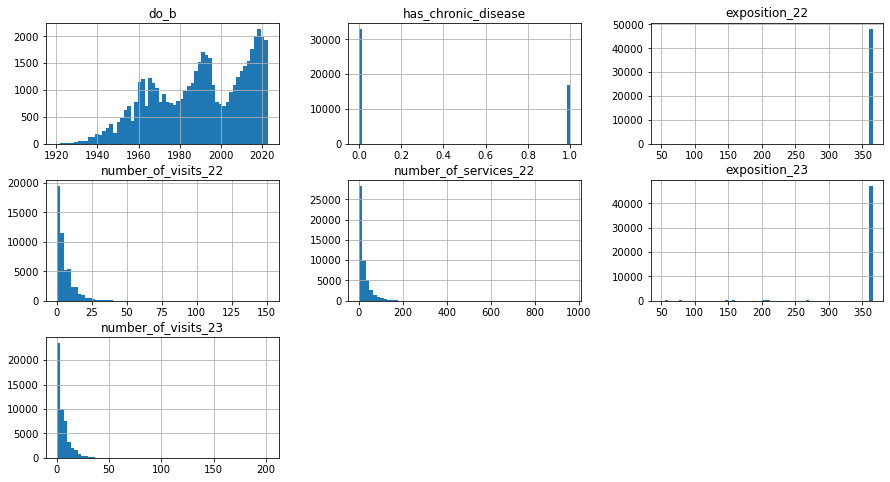

In [9]:
data.hist(figsize = (15, 8), bins = 60);

#### Выводы по результатам предварительного изучения данных датасета `data`, содержащего информацию об использовании медицинских услуг клиентами в 2022 и 2023 годах

- в датасете **50 000** строк, **12** столбцов
- **все** столбцы имеют правильные типы данных, соответствующие содержанию
- в качестве индекса мы использовали идентификаторы клиентов, все идентификаторы **уникальны**
- имеется **8775** пропущенных значений в двух столбцах
- имеется **2220** полных дубликатов (за исключением идентификаторов клиентов), **удалим** их, так как дубликаты могут служить подсказкой при кросс-валидации
- недостоверных, отрицательых значений **не выявлено**
---
- столбец `insured__network` - идентификатор сети клиник, всего **8** уникальных значений, большая часть выборки обслуживается в сети `Network-2`
- столбец `nationality` - признак национальности,  всего **6** уникальных значений, основная часть выборки имеет значение `Saudi`
- столбец `gender` - пол,  все традиционно, **2** уникальных значения, мужчин чуть больше, чем женщин
- столбец `relation` - кем клиент является страхователю, всего **5** уникальных значений, самое частое - `Self`, то есть сам страхователь
- столбец `do_b` - дата рождения клиента, самый пожилой клиент родился в 1920 году, самые молодые - в 2022, половина клиентов родилась в 2011 году и позднее; имеется один пропуск, предлагается **удалить** этот объект, так как данных в выборке достаточно для обучения
- столбец `diagnoses` - перечень с выявленными у клиента диагнозами; имеется **8775** пропущенных значений, предлагается заполнить их **константой**, не встречающейся в данном признаке; анализ и использование в моделировании содержимого данного столбца может дать дополнительное улучшение точности прогноза
- столбец `has_chronic_disease` - признак наличия хронических заболеваний, признак бинарный, большая часть клиентов хронических заболеваний **не имеет**
- столбец `exposition_22` - количество дней обслуживания в 22 году, минимальное значение **50**, максимальное - **365**
- столбец `number_of_visits_22` - количество посещений клиники в 22 году, минимальное значение **0**, максимальное - **151**, 75% клиентов имеют 8 и менее визитов
- столбец `number_of_services_22` - количество оказанных услуг клиники в 22 году, минимальное значение **0**, максимальное - **962**, 75% клиентов имеют 31 и менее оказаных услуг
- столбец `exposition_23` - количество дней обслуживания в 23 году, минимальное значение **50**, максимальное - **365**
- столбец `number_of_visits_23` - **целевой признак** - количество посещений клиники в 23 году, минимальное значение **0**, максимальное - **202**
---
- **5** признаков (`insured__network`, `nationality`, `gender`, `relation`, `has_chronic_disease`) - **категориальные**, 
- **1 признак** `diagnoses` - **текстовый**
- остальные - **количественные**

### Изучим датасет `holdout`

In [10]:
description(holdout)

 
Общая информация: 
 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1516424 to 1384402
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   insured__network       10000 non-null  object        
 1   nationality            10000 non-null  object        
 2   gender                 10000 non-null  object        
 3   relation               10000 non-null  object        
 4   do_b                   10000 non-null  datetime64[ns]
 5   diagnoses              8274 non-null   object        
 6   has_chronic_disease    10000 non-null  int64         
 7   exposition_22          10000 non-null  int64         
 8   number_of_visits_22    10000 non-null  int64         
 9   number_of_services_22  10000 non-null  int64         
 10  exposition_23          10000 non-null  int64         
dtypes: datetime64[ns](1), int64(5), object(5)
memory usage: 937.5+ KB


,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23
Insured_PIN,,,,,,,,,,,
1516424,Network-2,Saudi,Female,Child,2012-09-06,A09,0,365,1,3,365
22210474,Network-1,Saudi,Female,Child,1995-10-26,T78.4;R50.9;Z01.8;R05,0,365,4,22,365


,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23
Insured_PIN,,,,,,,,,,,
62818434,Network-2,Group 2,Female,Child,2007-04-11,L73.9,0,365,1,2,365
1384402,Network-2,Saudi,Female,Spouse,1987-11-30,K58.9;J06.9;R21;H10;T14;R10.4;E55;J20;L30.9;M17.0;L30;J06;L20;M13;M25.5;R51;K29;J01;R50.9;J03.9;J45.9;R03.0;J00;J30.0;R69;H11.3;H66;E79;UNK;M10.9;N76;M79.10;J30.4;J02;M13.9;J02.9;J30,1,365,32,100,365



 Количество дубликатов:  414
 Пропущенных значений:  1726
 Уникальных индексов:  10000

  Статистические характеристики датасета: 


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
insured__network,10000,8,Network-2,9277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nationality,10000,6,Saudi,9311,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gender,10000,2,Male,5046,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relation,10000,5,Self,4321,NaN,NaN,NaN,NaN,NaN,NaN,NaN
do_b,10000,NaN,NaN,NaN,1990-02-05 12:24:02.880000128,1922-02-13 00:00:00,1970-09-01 18:00:00,1991-11-09 12:00:00,2011-02-19 06:00:00,2022-11-12 00:00:00,NaN
diagnoses,8274,7434,J02,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN
has_chronic_disease,10000.0,NaN,NaN,NaN,0.338,0.0,0.0,0.0,1.0,1.0,0.473052
exposition_22,10000.0,NaN,NaN,NaN,359.4261,50.0,365.0,365.0,365.0,365.0,33.756826
number_of_visits_22,10000.0,NaN,NaN,NaN,5.8236,0.0,1.0,4.0,8.0,113.0,6.789425
number_of_services_22,10000.0,NaN,NaN,NaN,22.9913,0.0,3.0,13.0,31.0,495.0,30.820412


 
Изучим 5 минимальных и 5 максимальных значений каждого столбца:  

insured__network Уникальных значений: 8
['Network-1', 'Network-2', 'Network-3', 'Network-4', 'Network-5'] ..... ['Network-4', 'Network-5', 'Network-6', 'Network-7'] Network-8 

nationality Уникальных значений: 6
['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Others'] ..... ['Group 2', 'Group 3', 'Group 4', 'Others'] Saudi 

gender Уникальных значений: 2
['Female', 'Male'] ..... ['Female'] Male 

relation Уникальных значений: 5
['Child', 'Other', 'Parent', 'Self', 'Spouse'] ..... ['Child', 'Other', 'Parent', 'Self'] Spouse 

do_b Уникальных значений: 6275
[numpy.datetime64('1922-02-13T00:00:00.000000000'), numpy.datetime64('1922-02-27T00:00:00.000000000'), numpy.datetime64('1927-01-04T00:00:00.000000000'), numpy.datetime64('1928-11-18T00:00:00.000000000'), numpy.datetime64('1928-12-13T00:00:00.000000000')] ..... [numpy.datetime64('2022-10-31T00:00:00.000000000'), numpy.datetime64('2022-11-02T00:00:00.000000000'), numpy.

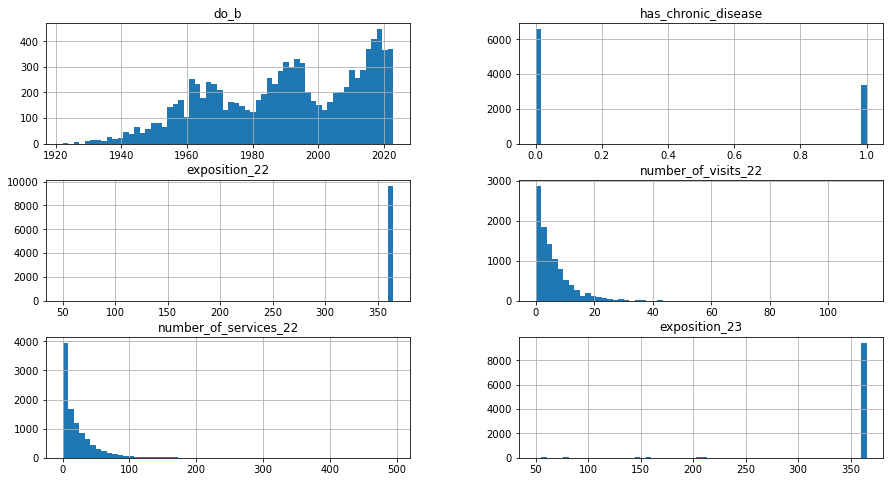

In [11]:
holdout.hist(figsize = (15, 8), bins = 60);

#### Выводы по результатам предварительного изучения данных датасета `holdout`, содержащего информацию о клентах для совершения тестового предсказания

- в датасете **10 000** строк, **11** столбцов (отсутствует столбец с **целевым признаком**)
- **все** столбцы имеют правильные типы данных, соответствующие содержанию
- в качестве индекса мы использовали идентификаторы клиентов, все идентификаторы **уникальны**
- имеется **1726** пропущенных значений в столбце `diagnoses`, заполним их константой, аналогично обучающей выборке
- имеется **414** полных дубликатов (за исключением идентификаторов клиентов), **оставим** их, так как данные не будут участвовать в обучении моделей
- недостоверных, отрицательных значений **не выявлено**
- значений признаков, отсутствующих в обучающей выборке, **не выявлено**


## Подготовим массив признаков и вектор целевого признака для обучения моделей

### Удалим строку с пропущенной датой

In [12]:
data.dropna(subset=['do_b'], inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49999 entries, 1006786 to 9952098
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   insured__network       49999 non-null  object        
 1   nationality            49999 non-null  object        
 2   gender                 49999 non-null  object        
 3   relation               49999 non-null  object        
 4   do_b                   49999 non-null  datetime64[ns]
 5   diagnoses              41225 non-null  object        
 6   has_chronic_disease    49999 non-null  int64         
 7   exposition_22          49999 non-null  int64         
 8   number_of_visits_22    49999 non-null  int64         
 9   number_of_services_22  49999 non-null  int64         
 10  exposition_23          49999 non-null  int64         
 11  number_of_visits_23    49999 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(5)
memory usa

- из датасета `data` **удалена** одна строка с пропущенной датой рождения

### Создадим массив признаков и вектор целевого признака

In [13]:
target = data['number_of_visits_23']
features = data.drop(['number_of_visits_23'], axis = 1)

In [14]:
display(features.head(2))
print('Размерность массива признаков', features.shape)
print('Размерность вектора целевого признака', target.shape)

,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23
Insured_PIN,,,,,,,,,,,
1006786,Network-4,Group 2,Male,Self,1974-04-28,NaN,0,365,0,0,365
1008861,Network-2,Saudi,Female,Child,2017-07-27,J20.9;J02,0,365,1,2,365


Размерность массива признаков (49999, 11)
Размерность вектора целевого признака (49999,)


In [15]:
target.head(2)

Insured_PIN
1006786    0
1008861    4
Name: number_of_visits_23, dtype: int64

- из датасета `data` создан **массив признаков**  и вектор **целевого признака** обучающей выборки: `features` и `target`

### Разделим выборку на `обучающую` и `проверочную`

In [16]:
features_train, features_valid, target_train, target_valid = train_test_split(features, target, 
                            random_state = RANDOM_STATE,
                            shuffle = True,
                            test_size = TEST_SIZE)

In [17]:
display(features_train.shape,
        round(features_train.shape[0]/features.shape[0], 2),
        features_valid.shape,
        round(features_valid.shape[0]/features.shape[0], 2))
display(target_train.shape, target_valid.shape)

(39999, 11)

0.8

(10000, 11)

0.2

(39999,)

(10000,)

- из датасета `data` созданы `обучающая` и `проверочная` выборки в пропорции **80%** на **20%**, размер `проверочной` выборки соответствует размеру `holdout`

### Объявим класс `feature_creator`, который создаст новый набор признаков для обучения

- в процессе обучения моделей предпринималась попытка использовать **векторизированные текстовые значения** из признака `diagnoses`, но это не привело к заметному улучшению метрики (чуть более 1%) и существенно замедлило работу моделей (практически в 50 раз)
- также предпринималась попытка закодировать значения строк с применением `StandardEncoder`, что привело к **ухудшению** метрики
- было принято решение заменить данный признак на признак длины строки, содержащей описание диагнозов, так как применение данного признака несколько улучшает метрику и не замедляет скорость работы моделей

In [18]:
class feature_creator (BaseEstimator, TransformerMixin):
    
    '''
    Класс `feature_creator` принимает на вход выборку и осуществляет следующие
    преобразования в методе `transform`:
        - создает из столбца `do_b` признаки года, месяца и дня рождения
        - заполняет пропуски в столбце `diagnoses` значением `u` (`unknown`)
        - создает из столбца `diagnoses` новый признак длины диагноза `diagnoses` 
    '''
  
    
    def fit(self, data_train, target_train = None):
        self.data_train = data_train.copy(deep = True)
       
        return self
    
      ################################

    def transform(self, data_test, target_test = None):
        
        data_test = data_test.copy(deep = True)

        # Создадим из даты рождения признаки года, месяца и дня рождения      
        data_test['y_o_b'] = data_test['do_b'].dt.year
        data_test['m_o_b'] = data_test['do_b'].dt.month
        data_test['do_b'] = data_test['do_b'].dt.day

        #Заполним пропуски в столбце `diagnoses` значением `unknown`
        data_test['diagnoses'].fillna('u', inplace = True)
        
        # Заменим перечень диагнозов общей длиной строки
        data_test['diagnoses'] = data_test['diagnoses'].apply(len)
    
        return data_test
    
    ###########################################################################
    
    def fit_transform(self, data_train, target_train = None):
        
        data_train = data_train.copy(deep = True)
        
        self = self.fit(data_train)
        data_train = self.transform(self.data_train)

        return data_train

### Проверим работу класса и создадим датасет `data_eda` с новыми признаками для последующего исследовательского анализа

In [19]:
transformer = feature_creator()

In [20]:
transformer.fit(features)

feature_creator()

In [21]:
data_eda = transformer.transform(features)

In [22]:
data_eda.tail(2)

,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,y_o_b,m_o_b
Insured_PIN,,,,,,,,,,,,,
9950431,Network-1,Group 4,Male,Self,13,66,1,365,14,56,365,1966,8
9952098,Network-1,Group 4,Female,Child,12,3,0,365,1,5,365,2008,1


In [23]:
data_eda = transformer.fit_transform(features)

In [24]:
data_eda.tail(2)

,insured__network,nationality,gender,relation,do_b,diagnoses,has_chronic_disease,exposition_22,number_of_visits_22,number_of_services_22,exposition_23,y_o_b,m_o_b
Insured_PIN,,,,,,,,,,,,,
9950431,Network-1,Group 4,Male,Self,13,66,1,365,14,56,365,1966,8
9952098,Network-1,Group 4,Female,Child,12,3,0,365,1,5,365,2008,1


In [25]:
print(data_eda.shape)

(49999, 13)


- создание новых признаков проходит **корректно**

---

## Проведем исследовательский анализ признаков

### Добавим к исследовательскому датасету `data_eda` столбец со значением `целевого` признака для исследования корреляции

In [26]:
data_eda['number_of_visits_23'] = target

### Объявим функцию для определения категориальных, текстовых и количественных признаков

In [27]:
def interval_categorical_text(data, threshold = 10):
    '''
    Функция принимает на входе датасет `data` и порог `threshold` отнесения к категориальным признакам, 
    и возвращает перечни столбцов датасета, содержащие количественные, категориальные  и текстовые признаки.
    
    Значение порога `threshold` по умолчанию равно 10
    '''
    
    interval_cols = []
    categorical_cols = []
    text_cols = []
    
    for column in data.columns:
        if (data[column].dtype == 'object') & (data[column].nunique() > threshold):
            text_cols.append(column)
        
        elif data[column].nunique() > threshold:
            interval_cols.append(column)
            
        else:
            categorical_cols.append(column)
            
            
    print('\ninterval_cols\n', sorted(interval_cols))
    print('\ncategorical_cols\n', sorted(categorical_cols))
    print('\ntext_cols\n', sorted(text_cols))
    
    return interval_cols, categorical_cols, text_cols

In [28]:
interval_cols, categorical_cols, text_cols = interval_categorical_text(data_eda)


interval_cols
 ['diagnoses', 'do_b', 'exposition_22', 'exposition_23', 'm_o_b', 'number_of_services_22', 'number_of_visits_22', 'number_of_visits_23', 'y_o_b']

categorical_cols
 ['gender', 'has_chronic_disease', 'insured__network', 'nationality', 'relation']

text_cols
 []


### Изучим распределение количественных признаков в обучающей выборке

#### Изучим количество услуг и количество визитов в 22 году

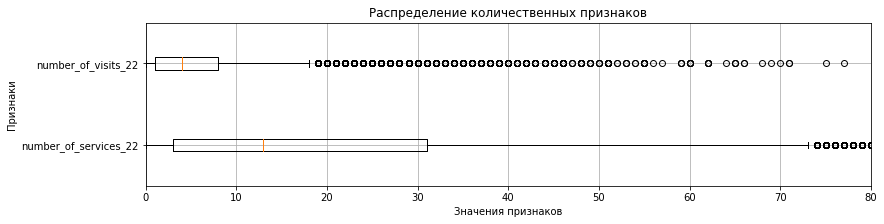

Минимальное значение выброса в признаке number_of_visits_22 : 19
Выбросов:  2408
Минимальное значение выброса в признаке number_of_services_22 : 74
Выбросов:  2893


In [29]:
features_list = ['number_of_services_22', 'number_of_visits_22']
plt.figure(figsize = (13, 3))
plt.title('Распределение количественных признаков')
plt.xlabel('Значения признаков')
plt.ylabel('Признаки')
plt.xlim(0, 80)
plt.grid(True)
boxplot = plt.boxplot(data_eda[features_list], 
                      labels = features_list,
                      vert = False);
plt.show()

for item in [1, 0]:
    outliers = list(boxplot["fliers"][item].get_data()[0]);
    outlier_min = sorted(outliers)[0]
    print("Минимальное значение выброса в признаке", features_list[item], ":", outlier_min)
    print("Выбросов: ", len(outliers))


- имеется большое количество `выбросов` в количестве посещений `number_of_visits_22` и количестве оказанных услуг `number_of_services_22`
>удаление строк с выбросами дало большое расхождение кросс-валидационных метрик, полученных на `обучающей` выборке с метрикой, полученной на `проверочной` выборке, при более худшем значении метрики на `проверочной` выборке по сравнению с оставленными строками, поэтому принято решение строки с выбросами **не удалять** и в качестве компенсации влияния выбросов на линейную регрессию использовать `RobustScaler`.

#### Изучим характеристики распределений вновь созданных календарных признаков и признака длины диагноза

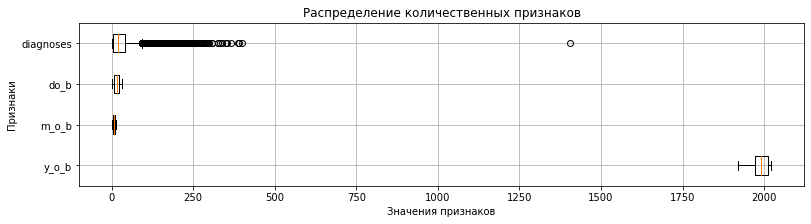

Минимальное значение выброса в признаке diagnoses : 93
Выбросов:  2454
Выбросы в признаке do_b отсутствут
Выбросы в признаке m_o_b отсутствут
Выбросы в признаке y_o_b отсутствут


In [30]:
features_list = ['y_o_b', 'm_o_b', 'do_b', 'diagnoses']
plt.figure(figsize = (13, 3))
plt.title('Распределение количественных признаков')
plt.xlabel('Значения признаков')
plt.ylabel('Признаки')
#plt.xlim(0, 80)
plt.grid(True)
boxplot = plt.boxplot(data_eda[features_list], 
                      labels = features_list,
                      vert = False);
plt.show()

for item in [3, 2, 1, 0]:
    outliers = list(boxplot["fliers"][item].get_data()[0]);
    try:
        outlier_min = sorted(outliers)[0] 
        print("Минимальное значение выброса в признаке", features_list[item], ":", outlier_min)
        print("Выбросов: ", len(outliers))
    except:
         print("Выбросы в признаке", features_list[item], "отсутствут")


- во вновь созданных календарных признаках `do_b`, `m_o_b` и `y_o_b` выбросы **отсутствуют**
- во вновь созданном признаке длины диагноза `diagnoses` имеются множественные выбросы, однако удаление признака приводит к незначительному ухудшению точности прогноза, принято решение признак **оставить**

### Изучим корреляцию признаков с целевым признаком и мультиколлинеарность

In [31]:
corr_matrix = data_eda.phik_matrix(
    interval_cols = interval_cols)
corr_matrix['number_of_visits_23'].sort_values(ascending = False)

number_of_visits_23      1.000000
number_of_services_22    0.879726
number_of_visits_22      0.861390
diagnoses                0.433246
has_chronic_disease      0.238394
relation                 0.085011
y_o_b                    0.084215
exposition_22            0.026848
gender                   0.026282
exposition_23            0.019633
do_b                     0.015032
insured__network         0.000000
nationality              0.000000
m_o_b                    0.000000
Name: number_of_visits_23, dtype: float64

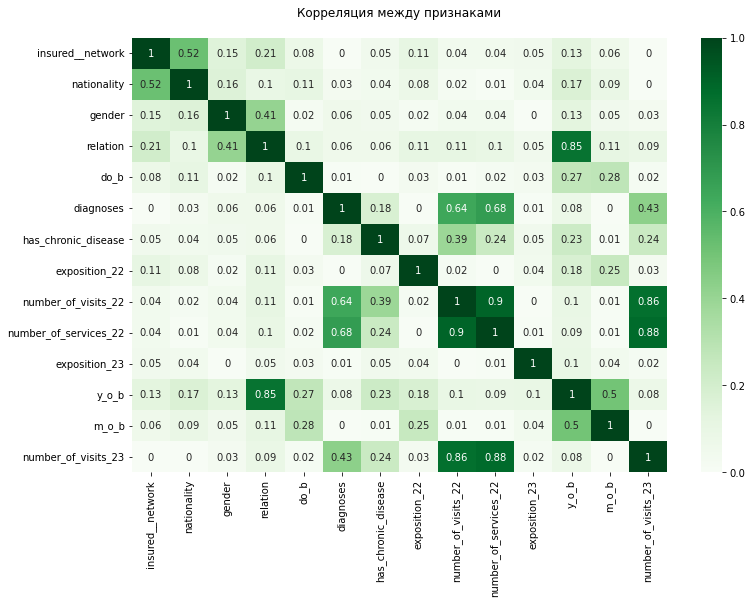

In [32]:
plt.figure(figsize = (12, 8))
plt.title('Корреляция между признаками\n');
sns.heatmap(round(abs(corr_matrix), 2),
            annot = True,
            cmap = 'Greens');
plt.show()

- имеется **сильная** корреляция **целевого** признака с `number_of_services_22` и `number_of_visits_22`
- имеется **средняя** корреляция **целевого** признака с вновь созданным признаком длины диагноза `diagnoses`
- имеется **слабая** корреляция **целевого** признака с `has_chronic_disease`
- с остальными признаками корреляция **не прослеживается**
---
- имеется **сильная** **мультиколлинеарность** между признаками `number_of_services_22` и `number_of_visits_22`, а также между вновь созданным признаком года рождения `y_o_b` и признаком родственности страхователю `relation`, однако **удаление** одного признака из пары связанных признаков или их **объединение** привело к **ухудшению** значения метрик, принято решение все признаки оставить **без изменения**

## Обучим модели методом кросс-валидации

### Удалим дубликаты в обучающей выборке

In [33]:
features_train.drop_duplicates(inplace = True)
target_train = target_train[features_train.index]

In [34]:
print(features_train.shape, target_train.shape )

(37791, 11) (37791,)


- из обучающей выборки `features_train` **удалены** дубликаты

### Объявим преобразователи для использования в процессе обучения методом кросс-валидации

#### Объявим функцию для преобразования признаков

In [35]:
preprocessor = feature_creator()

#### Определим функцию, выравнивающую масштаб признаков

In [36]:
rscaler = RobustScaler() # Для линейной регрессии

In [37]:
scaler = StandardScaler() # Для модели с регуляризацией

#### Зададим функции, кодирующие признаки

In [38]:
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
ore = OrdinalEncoder(handle_unknown = 'use_encoded_value', unknown_value = -1,
                   encoded_missing_value=-100)

### Обучим  модель `LinearRegression` методом `кросс-валидации`

#### Зададим неизменяемые гиперпараметры модели

In [39]:
lr = LinearRegression(n_jobs=-1)

#### Зададим обработчик столбцов для разделения обработки количественых и категориальных признаков

In [40]:
lr_column_transformer = ColumnTransformer(
    [("ohe", ohe, categorical_cols)],
    remainder='passthrough')

#### Сконструируем конвейер для предобработки данных и обучения модели

In [41]:
lr_pipe = Pipeline(steps=[
    ("feature_creator", preprocessor),
    ("lr_column_transformer", lr_column_transformer),
    ("rscaler", rscaler),
    ("lr", lr)])
print(lr_pipe)

Pipeline(steps=[('feature_creator', feature_creator()),
                ('lr_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['insured__network',
                                                   'nationality', 'gender',
                                                   'relation',
                                                   'has_chronic_disease'])])),
                ('rscaler', RobustScaler()),
                ('lr', LinearRegression(n_jobs=-1))])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `MSE` методом `кросс-валидации`

In [42]:
lr_param_grid = {}

#### Объявим функцию поиска оптимальных гиперпараметров

In [43]:
lr_search = GridSearchCV(
    lr_pipe,
    lr_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 10,
    verbose = 1
)

#### Проведем поиск оптимальных гиперпараметров

In [44]:
lr_search.fit(features_train, target_train)

Fitting 10 folds for each of 1 candidates, totalling 10 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('feature_creator', feature_creator()),
                                       ('lr_column_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['insured__network',
                                                                          'nationality',
                                                                          'gender',
                                                                          'relation',
                                                                          'has_chronic_disease'])])),
                                       ('rscaler', RobustScaler()),
                                       ('lr', LinearRegression(n_jobs=-1))]),
             param_grid={}, scoring='neg_mean_squared_error', verbose=1)

In [45]:
print("\nЛучшее полученное методом кросс-валидации \n \
значение метрики MSE = %0.2f:" % -lr_search.best_score_,
"найдено при следующих параметрах")
print(lr_search.best_params_)


Лучшее полученное методом кросс-валидации 
 значение метрики MSE = 25.24: найдено при следующих параметрах
{}


#### Выводы по результатам обучения модели `LinearRegression`

- лучшее полученное методом кросс-валидации значение метрики `MSE` = **25.24**

### Обучим модель `SGDRegressor` методом `кросс-валидации`

#### Зададим неизменяемые гиперпараметры модели

In [46]:
sgd = SGDRegressor(
    random_state = RANDOM_STATE,
    alpha=0.0001,
    max_iter=10000, 
    shuffle=True, 
    verbose=0, 
    epsilon=0.1, 
    eta0=0.01, 
    power_t=0.5,
    early_stopping=True, 
    validation_fraction=0.1,
    n_iter_no_change=5
    )

#### Зададим обработчик столбцов для разделения обработки количественых и категориальных признаков

In [47]:
sgd_column_transformer = ColumnTransformer(
    [("ohe", ohe, categorical_cols)],
    remainder='passthrough')

#### Сконструируем конвейер для предобработки данных и обучения модели

In [48]:
sgd_pipe = Pipeline(steps=[
    ("feature_creator", preprocessor),
    ("sgd_column_transformer", sgd_column_transformer),
    ("scaler", scaler),
    ("sgd", sgd)])
print(sgd_pipe)

Pipeline(steps=[('feature_creator', feature_creator()),
                ('sgd_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['insured__network',
                                                   'nationality', 'gender',
                                                   'relation',
                                                   'has_chronic_disease'])])),
                ('scaler', StandardScaler()),
                ('sgd',
                 SGDRegressor(early_stopping=True, max_iter=10000, power_t=0.5,
                              random_state=53))])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `MSE` методом `кросс-валидации`

> Поиск гиперпараметров проводился на 100 попытках в следующих диапазонах:
>```
>'sgd__l1_ratio': FloatDistribution(0.00001, 1),
>'sgd__learning_rate': CategoricalDistribution(['constant', 'adaptive', 'invscaling']),
>'sgd__penalty': CategoricalDistribution(['l2', 'l1', 'elasticnet', None]),
>'sgd__loss': CategoricalDistribution(['squared_error', 'huber', 'epsilon_insensitive',
                                      'squared_epsilon_insensitive']
>```

In [49]:
sgd_param_grid = {
   'sgd__l1_ratio': FloatDistribution(0.17899038853601035, 0.17899038853601035),
   'sgd__learning_rate': CategoricalDistribution(['invscaling']),
   'sgd__penalty': CategoricalDistribution(['l1']),
   'sgd__loss': CategoricalDistribution(['squared_epsilon_insensitive'])
                      }

#### Объявим функцию поиска оптимальных гиперпараметров

In [50]:
sgd_search = OptunaSearchCV(
    sgd_pipe,
    sgd_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 10,
    verbose = 0,
    n_trials=1, # Подбор осуществлялся на 100 попытках, сокращено для ускорения пересчета
    random_state = RANDOM_STATE
)

/tmp/ipykernel_139540/1752522297.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  sgd_search = OptunaSearchCV(


#### Проведем поиск оптимальных гиперпараметров

In [51]:
sgd_search.fit(features_train, target_train)

[I 2024-04-08 14:05:09,448] A new study created in memory with name: no-name-ffa030af-686c-4fb6-8a5f-200d222deac0
[I 2024-04-08 14:05:12,871] Trial 0 finished with value: -25.267470549447644 and parameters: {'sgd__l1_ratio': 0.17899038853601035, 'sgd__learning_rate': 'invscaling', 'sgd__penalty': 'l1', 'sgd__loss': 'squared_epsilon_insensitive'}. Best is trial 0 with value: -25.267470549447644.


OptunaSearchCV(cv=10,
               estimator=Pipeline(steps=[('feature_creator', feature_creator()),
                                         ('sgd_column_transformer',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ohe',
                                                                           OneHotEncoder(drop='first',
                                                                                         handle_unknown='ignore'),
                                                                           ['insured__network',
                                                                            'nationality',
                                                                            'gender',
                                                                            'relation',
                                                                            'has_chronic_disease'])])),
                                         ('scaler', StandardScaler()),
                                         ('sgd',
                                          SGDRegre...
               param_distributions={'sgd__l1_ratio': FloatDistribution(high=0.17899038853601035, log=False, low=0.17899038853601035, step=None),
                                    'sgd__learning_rate': CategoricalDistribution(choices=('invscaling',)),
                                    'sgd__loss': CategoricalDistribution(choices=('squared_epsilon_insensitive',)),
                                    'sgd__penalty': CategoricalDistribution(choices=('l1',))},
               random_state=53, scoring='neg_mean_squared_error')

In [52]:
print("\nЛучшее полученное методом кросс-валидации \n \
значение метрики MSE = %0.2f:" % -sgd_search.best_score_,
"найдено при следующих параметрах")
print(sgd_search.best_params_)


Лучшее полученное методом кросс-валидации 
 значение метрики MSE = 25.27: найдено при следующих параметрах
{'sgd__l1_ratio': 0.17899038853601035, 'sgd__learning_rate': 'invscaling', 'sgd__penalty': 'l1', 'sgd__loss': 'squared_epsilon_insensitive'}


#### Выводы по результатам обучения модели `SGDRegressor`

- лучшее полученное методом кросс-валидации значение метрики `MSE` = **25.27**, что **хуже** значения метрики модели `LinearRegression`

### Обучим модель `RandomForestRegressor`

#### Зададим неизменяемые гиперпараметры модели

In [53]:
rf = RandomForestRegressor(
    random_state = RANDOM_STATE,
    n_jobs = -1,
    verbose=False)

#### Зададим обработчик столбцов для разделения обработки количественых и категориальных признаков

In [54]:
rf_column_transformer = ColumnTransformer(
   [("ore", ore, categorical_cols)],
    remainder='passthrough')

#### Сконструируем конвейер для балансировки данных и обучения модели

In [55]:
rf_pipe = Pipeline(steps=[
    ("feature_creator", preprocessor),
    ("rf_column_transformer", rf_column_transformer),
    ("rf", rf)])
print(rf_pipe)

Pipeline(steps=[('feature_creator', feature_creator()),
                ('rf_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ore',
                                                  OrdinalEncoder(encoded_missing_value=-100,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['insured__network',
                                                   'nationality', 'gender',
                                                   'relation',
                                                   'has_chronic_disease'])])),
                ('rf',
                 RandomForestRegressor(n_jobs=-1, random_state=53,
                                       verbose=False))])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `MSE` методом `кросс-валидации`

>Поиск гиперпараметров осуществлялся на 100 попытках в следующих диапазонах:
>```
'rf__criterion': CategoricalDistribution(['squared_error', 'friedman_mse', 'poisson']),
'rf__max_depth': IntDistribution(1, 500),
'rf__n_estimators': IntDistribution(1, 1000),
'rf__min_samples_split': IntDistribution(2, 200),
'rf__min_samples_leaf': IntDistribution(1, 200),
```

In [56]:
rf_param_grid = {
    'rf__criterion': CategoricalDistribution(['squared_error']),
    'rf__max_depth': IntDistribution(340, 340),
    'rf__n_estimators': IntDistribution(395, 395),
    'rf__min_samples_split': IntDistribution(128, 128),
    'rf__min_samples_leaf': IntDistribution(1, 1),
                 }

#### Объявим функцию поиска оптимальных гиперпараметров

In [57]:
rf_search = OptunaSearchCV(
    rf_pipe,
    rf_param_grid,
    scoring = 'neg_mean_squared_error',
    cv = 10,
    verbose = 0,
    #n_jobs = -1,
    n_trials=1, # Поиск осуществлялся на 100 попытках, сокращено для ускорения пересчета
    random_state = RANDOM_STATE
)

/tmp/ipykernel_139540/4268647168.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  rf_search = OptunaSearchCV(


#### Проведем поиск оптимальных гиперпараметров

In [58]:
rf_search.fit(features_train, target_train)

[I 2024-04-08 14:05:13,389] A new study created in memory with name: no-name-154b24dc-24f1-42ce-b80f-0204ea2040b2
[I 2024-04-08 14:06:09,938] Trial 0 finished with value: -25.265730920011784 and parameters: {'rf__criterion': 'squared_error', 'rf__max_depth': 340, 'rf__n_estimators': 395, 'rf__min_samples_split': 128, 'rf__min_samples_leaf': 1}. Best is trial 0 with value: -25.265730920011784.


OptunaSearchCV(cv=10,
               estimator=Pipeline(steps=[('feature_creator', feature_creator()),
                                         ('rf_column_transformer',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ore',
                                                                           OrdinalEncoder(encoded_missing_value=-100,
                                                                                          handle_unknown='use_encoded_value',
                                                                                          unknown_value=-1),
                                                                           ['insured__network',
                                                                            'nationality',
                                                                            'gender',
                                                                            'relation',
                                                                            'has_chronic_disease'])])),
                                         (...
               param_distributions={'rf__criterion': CategoricalDistribution(choices=('squared_error',)),
                                    'rf__max_depth': IntDistribution(high=340, log=False, low=340, step=1),
                                    'rf__min_samples_leaf': IntDistribution(high=1, log=False, low=1, step=1),
                                    'rf__min_samples_split': IntDistribution(high=128, log=False, low=128, step=1),
                                    'rf__n_estimators': IntDistribution(high=395, log=False, low=395, step=1)},
               random_state=53, scoring='neg_mean_squared_error')

In [59]:
print("\nЛучшее полученное методом кросс-валидации \n\
значение метрики MSE = %0.2f:" % -rf_search.best_score_,
"найдено при следующих гиперпараметрах")
print(rf_search.best_params_)


Лучшее полученное методом кросс-валидации 
значение метрики MSE = 25.27: найдено при следующих гиперпараметрах
{'rf__criterion': 'squared_error', 'rf__max_depth': 340, 'rf__n_estimators': 395, 'rf__min_samples_split': 128, 'rf__min_samples_leaf': 1}


#### Выводы по результатам обучения модели `RandomForestRegressor`

- в результате подбора гиперпараметров, обучения и кросс-валидации модели `RandomForestRegressor` было получено значение метрики `MSE` = **25.27**, что **хуже** метрики линейной регрессии, кроме того модель обучается значительно дольше

### Обучим модель `CatBoostRegressor`

#### Зададим неизменяемые гиперпараметры модели

In [60]:
cb = CatBoostRegressor(
    random_seed = RANDOM_STATE,
    #cat_features = categorical_cols, # Не дает улучшения метрики
   # text_features = text_cols, # Использование встроенного анализатора текстов дает улучшение метрики на 1%,
    # но увеличивает время обучения модели в примерно в 50 раз
    verbose=False)

#### Зададим обработчик столбцов для разделения обработки количественых и категориальных признаков

In [61]:
cb_column_transformer = ColumnTransformer(
   [("ore", ore, categorical_cols)],
    remainder='passthrough')

#### Сконструируем конвейер для предобработки данных и обучения модели

In [62]:
cb_pipe = Pipeline(steps=[
    ("feature_creator", preprocessor),
    ("cb_column_transformer", cb_column_transformer),
    ("cb", cb)])
print(cb_pipe)

Pipeline(steps=[('feature_creator', feature_creator()),
                ('cb_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ore',
                                                  OrdinalEncoder(encoded_missing_value=-100,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['insured__network',
                                                   'nationality', 'gender',
                                                   'relation',
                                                   'has_chronic_disease'])])),
                ('cb',
                 <catboost.core.CatBoostRegressor object at 0x7f7958916d10>)])


#### Зададим диапазоны гиперпараметров для поиска оптимальной метрики `MSE` методом `кросс-валидации`

>подбор гиперпараметров осуществлялся на 100 попытках в следующих диапазонах:
>```
'cb__learning_rate': FloatDistribution(0.0001, 1.0),
'cb__iterations': IntDistribution(50, 650),
'cb__depth': IntDistribution(1, 9),
```

In [63]:
cb_param_grid = {
    'cb__learning_rate': FloatDistribution(0.07692727065628183, 0.07692727065628183),
    'cb__iterations': IntDistribution(635, 635),
    'cb__depth': IntDistribution(3, 3),
                }

#### Объявим функцию `GridSearchCV` для поиска оптимальных гиперпараметров

In [64]:
cb_search = OptunaSearchCV(
                 cb_pipe,
                 cb_param_grid,
                 cv = 10,
                 scoring = 'neg_mean_squared_error',
                 verbose = 1,
                 n_trials=1, # Подбор осуществлялся на 100 попытках, сокращено для ускорения пересчета
                 random_state = RANDOM_STATE
)

/tmp/ipykernel_139540/1023924759.py:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  cb_search = OptunaSearchCV(


#### Проведем поиск оптимальных гиперпараметров

In [65]:
cb_search.fit(features_train, target_train)

[I 2024-04-08 14:06:16,526] A new study created in memory with name: no-name-fcfcc911-b389-42df-8f39-b401b864942e
[I 2024-04-08 14:06:30,752] Trial 0 finished with value: -24.47844003281017 and parameters: {'cb__learning_rate': 0.07692727065628183, 'cb__iterations': 635, 'cb__depth': 3}. Best is trial 0 with value: -24.47844003281017.


OptunaSearchCV(cv=10,
               estimator=Pipeline(steps=[('feature_creator', feature_creator()),
                                         ('cb_column_transformer',
                                          ColumnTransformer(remainder='passthrough',
                                                            transformers=[('ore',
                                                                           OrdinalEncoder(encoded_missing_value=-100,
                                                                                          handle_unknown='use_encoded_value',
                                                                                          unknown_value=-1),
                                                                           ['insured__network',
                                                                            'nationality',
                                                                            'gender',
                                                                            'relation',
                                                                            'has_chronic_disease'])])),
                                         (...
                                          <catboost.core.CatBoostRegressor object at 0x7f7958916d10>)]),
               n_jobs=1, n_trials=1,
               param_distributions={'cb__depth': IntDistribution(high=3, log=False, low=3, step=1),
                                    'cb__iterations': IntDistribution(high=635, log=False, low=635, step=1),
                                    'cb__learning_rate': FloatDistribution(high=0.07692727065628183, log=False, low=0.07692727065628183, step=None)},
               random_state=53, scoring='neg_mean_squared_error', verbose=1)

In [66]:
print("\nЛучшее полученное методом кросс-валидации \n\
значение метрики MSE = %0.2f:" % (-cb_search.best_score_),
"найдено при следующих гиперпараметрах")
print(cb_search.best_params_)


Лучшее полученное методом кросс-валидации 
значение метрики MSE = 24.48: найдено при следующих гиперпараметрах
{'cb__learning_rate': 0.07692727065628183, 'cb__iterations': 635, 'cb__depth': 3}


#### Выводы по результатам обучения модели `CatBoostRegressor`

- в результате подбора гиперпараметров, обучения и кросс-валидации модели `CatBoostRegressor` было получено значение метрики `MSE` = **24.48**, что **превосходит метрики** остальных моделей (`LinearRegression`, `SGDRegressor` и `RandomForestRegressor`)
- модель `CatBoostRegressor` с гиперпараметрами:
    - `depth`: **3**
    - `iterations`: **635**
    - `learning_rate`: **0.0769**,

    может быть **рекомендована** для дальнейшей проверки

### Сохраним лучшую модель

In [67]:
joblib.dump(cb_search, "cb_model.pkl")

['cb_model.pkl']

### Загрузим сохраненную модель

In [68]:
cb_search = joblib.load("cb_model.pkl")

### Изучим важность признаков для лучшей модели: `CatBoostRegressor`

#### Изучим важность признаков по мнению модели

In [69]:
feature_new = preprocessor.fit_transform(features_train)

In [70]:
feature_new_names = feature_new.columns

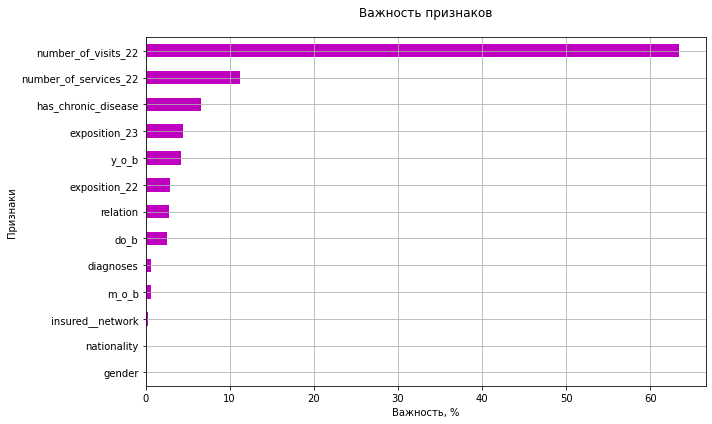

number_of_visits_22      63.417550
number_of_services_22    11.256987
has_chronic_disease       6.649617
exposition_23             4.408687
y_o_b                     4.203826
exposition_22             2.856349
relation                  2.754948
do_b                      2.490804
diagnoses                 0.647143
m_o_b                     0.587119
insured__network          0.277298
nationality               0.225530
gender                    0.224144
dtype: float64


In [71]:
cb_imp = pd.Series(
    cb_search.best_estimator_[-1].feature_importances_,
    index = feature_new_names).sort_values(ascending = True)
fig, ax = plt.subplots(figsize=(10, 6))
cb_imp.plot.barh(ax=ax, color = 'm')
ax.set_title("Важность признаков\n")
ax.set_xlabel('Важность, %')
ax.set_ylabel('Признаки')
fig.tight_layout()
ax.grid(True)
plt.show()
print(cb_imp.sort_values(ascending = False))

- анализ важности признаков, осуществленный моделью `CatBoostRegressor` демонстрирует, что:
    - **наиболее значимый** признак - это признак количества посещений в 22 году `number_of_visits_22`,
    - на **втором** месте идет признак количества оказанных услуг в 22 году  `number_of_services_22`,
    - затем идут признак наличия хронических заболеваний `has_chronic_disease`, количество дней обслуживания в 23 году `exposition_23`, год рождения `y_o_b`, `exposition_22`, `relation` и день месяца рождения `do_b`.
    
**Остальные признаки имеют существенно меньший вес**

#### Изучим ценность вклада каждого признака в предсказание с применением `векторов Шепли`

In [72]:
features_train_transformed = pd.DataFrame(cb_column_transformer.fit_transform(
    feature_new), columns = feature_new.columns)

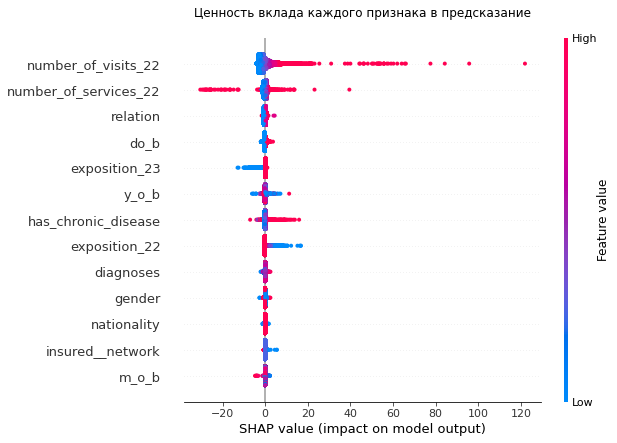

In [73]:
explainer = shap.Explainer(cb_search.best_estimator_[-1])
shap_values = explainer(features_train_transformed)
plt.title('Ценность вклада каждого признака в предсказание\n')
shap.plots.beeswarm(shap_values, max_display = 20)

- анализ **ценности вклада** каждого признака в предсказание с применением `векторов Шепли` демонстрирует, что два **наиболее значимых** признака: 
    - признак количества посещений в 22 году `number_of_visits_22` и
    - признак количества оказанных услуг в 22 году `number_of_services_22`,
    
    **совпадают** с оценкой значимости признаков, осуществленной самой моделью `CatBoostRegressor`
    - признаки длины диагноза `diagnoses`, пола `gender`, национальности `nationality`, месяца рождения `m_o_b` и сети клиник `insured__network` при анализе важности **обоими методами** признаны **самыми малозначимыми**
---
**Таким образом**
- признаки **`number_of_visits_22`** и **`number_of_services_22`** являются **наиболее** значимыми
- признаки `diagnoses`, `gender`, `nationality`, `m_o_b` и `insured__network` являются **наименее** значимыми

>в результате проведенного эксперимента установлено, что **удаление** малозначащих признаков приводит к небольшому ухудшению точности прогноза лучшей модели, принято решение все признаки **оставить**



## Проверим модель `CatBoostRegressor`

### Проверим значение метрики `MSE` на `проверочной` выборке

#### Обучим модель на обучающей выборке

In [74]:
%%time
cb_search.best_estimator_.fit(features_train, target_train)

CPU times: user 8.69 s, sys: 893 ms, total: 9.59 s
Wall time: 1.64 s


Pipeline(steps=[('feature_creator', feature_creator()),
                ('cb_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ore',
                                                  OrdinalEncoder(encoded_missing_value=-100,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['insured__network',
                                                   'nationality', 'gender',
                                                   'relation',
                                                   'has_chronic_disease'])])),
                ('cb',
                 <catboost.core.CatBoostRegressor object at 0x7f7958d10940>)])

#### Получим вектор `предсказаний` на `проверочной` выборке

In [75]:
%%time
cb_predictions_valid = (np.round(cb_search.best_estimator_.predict(
                                features_valid), 0)).astype('int64')

CPU times: user 74.9 ms, sys: 0 ns, total: 74.9 ms
Wall time: 61.3 ms


- время **обучения** модели составляет около **9** секунд, время **предсказания** модели составляет **менее секунды**, модель **подходит** для прогнозирования в **реальном времени**

In [76]:
cb_valid_mse = mean_squared_error(cb_predictions_valid, target_valid)
print('MSE на проверочной выборке: %0.2f'  %cb_valid_mse)
print('MSE на обучающей выборке: %0.2f' %-cb_search.best_score_)
print('Соотношение: %0.2f' %(-cb_search.best_score_/cb_valid_mse))

MSE на проверочной выборке: 23.75
MSE на обучающей выборке: 24.48
Соотношение: 1.03


- модель `CatBoostRegressor` на `проверочной` выборке показала значение метрики `MSE` = **23.75**, что сопоставимо со значением, полученным в ходе кросс-валидации (**24.48**) на `обучающей` выборке, разница составляет всего **3%**
- модель **устойчива**

###  Проверим модель на адекватность с помощью `DummyRegressor` на метрике `MAE`

In [77]:
dummy_model = DummyRegressor(strategy='median')
dummy_model.fit(features_train, target_train)
dummy_predictions_test = dummy_model.predict(features_valid)

mae_dummy = mean_absolute_error(target_valid, dummy_predictions_test)
mae_cb = mean_absolute_error(target_valid, cb_predictions_valid)

print("Метрика MAE фиктивной модели: %0.2f" % mae_dummy)
print("Метрика MAE модели CatBoostRegressor: %0.2f" % mae_cb)
print("Соотношение: %0.2f" % (mae_dummy/mae_cb))


mse_dummy = mean_squared_error(target_valid, dummy_predictions_test)
mse_cb = mean_squared_error(target_valid, cb_predictions_valid)
print()
print("Метрика MSE фиктивной модели: %0.2f" % mse_dummy)
print("Метрика MSE модели CatBoostRegressor: %0.2f" % mse_cb)
print("Соотношение: %0.2f" % (mse_dummy/mse_cb))
print()
r2_score_cb = r2_score(target_valid, cb_predictions_valid)
print("Коэффициент детерминации модели CatBoostRegressor: %0.2f" % r2_score_cb)


Метрика MAE фиктивной модели: 4.54
Метрика MAE модели CatBoostRegressor: 3.17
Соотношение: 1.43

Метрика MSE фиктивной модели: 50.21
Метрика MSE модели CatBoostRegressor: 23.75
Соотношение: 2.11

Коэффициент детерминации модели CatBoostRegressor: 0.49


- метрика средней абсолютной ошибки `MAE` модели `CatBoostRegressor` на `проверочной` выборке  практически в **полтора** раза меньше метрики фиктивной модели, которая всегда предсказывает `медианное` значение **целевого признака**
- метрика среднеквардатичной ошибки `MSE` модели `CatBoostRegressor` на `проверочной` выборке в **два** раза меньше аналогичной метрики фиктивной модели
- коэффициент детерминации `R2` модели больше **0**
- выбранная модель **адекватна**

### Выводы по результатам проверки модели `CatBoostRegressor`

- модель `CatBoostRegressor` на `проверочной` выборке показала значение метрики `MSE` = **23.75**, что сопоставимо со значением, полученным в ходе кросс-валидации (**24.48**) на `обучающей` выборке, разница составляет всего **3%**
- модель **устойчива**

- метрика средней абсолютной ошибки `MAE` модели `CatBoostRegressor` на `проверочной` выборке  практически в **полтора** раза меньше метрики фиктивной модели, которая всегда предсказывает `медианное` значение **целевого признака**
- метрика среднеквардатичной ошибки `MSE` модели `CatBoostRegressor` на `проверочной` выборке в **два** раза меньше аналогичной метрики фиктивной модели
- коэффициент детерминации `R2` модели больше **0**
- выбранная модель **адекватна**

- время **обучения** модели составляет около **9** секунд, время **предсказания** модели составляет **менее секунды**, модель **подходит** для прогнозирования в **реальном времени**

- модель `CatBoostRegressor` с гиперпараметрами:
    - `depth`: 3
    - `iterations`: 635
    - `learning_rate` = 0.0769,

    **предлагается к использованию** для прогнозирования активности клиентов добровольного медицинского страхования

---

## Предскажем вектор целевого признака `тестовой` выборки с применением модели `CatBoostRegressor`

### Обучим модель на полной `обучающей` выборке и получим вектор предсказаний на `тестовой` выборке

In [78]:
%%time
cb_search.best_estimator_.fit(features, target)

CPU times: user 10.7 s, sys: 1.13 s, total: 11.9 s
Wall time: 1.97 s


Pipeline(steps=[('feature_creator', feature_creator()),
                ('cb_column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ore',
                                                  OrdinalEncoder(encoded_missing_value=-100,
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['insured__network',
                                                   'nationality', 'gender',
                                                   'relation',
                                                   'has_chronic_disease'])])),
                ('cb',
                 <catboost.core.CatBoostRegressor object at 0x7f7958d10940>)])

In [79]:
%%time
cb_predictions_test = (np.round(cb_search.best_estimator_.predict(
                                holdout), 0)).astype('int64')

cb_predictions_test = pd.DataFrame(cb_predictions_test,
                                   index = holdout.index,
                                   columns = ['number_of_visits_23'])

CPU times: user 72.2 ms, sys: 0 ns, total: 72.2 ms
Wall time: 59.2 ms


In [80]:
cb_predictions_test.info()
cb_predictions_test.head(3)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 1516424 to 1384402
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   number_of_visits_23  10000 non-null  int64
dtypes: int64(1)
memory usage: 414.3 KB


,number_of_visits_23
Insured_PIN,
1516424,2
22210474,5
1518945,6


- **создан** вектор целевого признака тестовой выборки, содержащий идентификаторы клиентов и прогноз числа посещений в 23 году

### Запишем вектор предсказаний на диск в формате `csv`

In [81]:
cb_predictions_test.to_csv('holdout_prediction.csv', index = True)

In [82]:
temp = pd.read_csv('holdout_prediction.csv')

In [83]:
temp.info()
temp.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Insured_PIN          10000 non-null  int64
 1   number_of_visits_23  10000 non-null  int64
dtypes: int64(2)
memory usage: 156.4 KB


,Insured_PIN,number_of_visits_23
0,1516424,2
1,22210474,5
2,1518945,6


- **создан** файл `holdout_prediction.csv`, содержащий идентификаторы застрахованых и прогноз посещений в 23 году

---   

## Отчет

### Описание задачи

- Доступны данные о количестве обращений за медицинской помощью по **50 000** застрахованным ДМС за 2022 год. 

Доступны 2 выборки: 

- `train` - выборка для обучения и валидации, 50 тыс. застрахованных с проставленными значениями `target`.
- `holdout` - выборка для финального замера качества модели. В этой выборке 10 000 застрахованных, истинные значения `target` скрыты.

Для оценки качества модели будет применяться метрика `MSE`.

**Задача:**
- На основании характеристик застрахованных и истории их обращений за 2022 год предсказать количество визитов за 2023 год. 


**Что должно быть в результате:**

- Рабочий ноутбук или файл .py, содержащий:
    - Код предобработки данных
    - Код обучения модели
    - Код тестирования модели
- Файл .csv с предсказаниями на выборке `holdout` с указанием ид застрахованного и предсказанием модели
- Список использованных признаков с указанием их значимости
- Комментарии по ходу выполнения задачи

### Предварительная обработка данных

- из датасета `data` **удалена** одна строка с пропущенной датой рождения

- из датасета `data` созданы `обучающая` и `проверочная` выборки в пропорции **80%** на **20%**, размер `проверочной` выборки соответствует размеру `holdout`

- из `обучающей` выборки `features_train` и `target_train` **удалены** дубликаты

- из датасета `holdout` никакая информация **не удалялась**

### Конструирование признаков

- объявлен класс `features_maker`, который осуществляет следующие преобразования признаков:
    - вместо признака даты рождения `do_b` созданы календарные признаки года `y_o_b`, месяца `m_o_b` и дня `do_b` рождения
    - вместо текстового признака `diagnoses` создан признак длины строки, описывающей имеющиеся у клиента диагнозы `diagnoses`
    

>- в процессе обучения моделей предпринималась попытка использовать **векторизированные текстовые значения** из признака `diagnoses`, но это не привело к заметному улучшению метрики (чуть более 1%) и существенно замедлило работу моделей (практически в 50 раз)
>- также предпринималась попытка закодировать значения строк с применением `StandardEncoder`, что привело к **ухудшению** метрики
>- было принято решение заменить данный признак на признак длины строки, содержащей описание диагнозов, так как применение данного признака несколько улучшает метрику и не замедляет скорость работы моделей

### Исследовательский анализ данных

- имеется большое количество **выбросов** в количестве посещений `number_of_visits_22` и количестве оказанных услуг `number_of_services_22`
>удаление строк с выбросами дало большое расхождение кросс-валидационных метрик, полученных на `обучающей` выборке с метрикой, полученной на `проверочной` выборке, при более худшем значении метрики на `проверочной` выборке по сравнению с оставленными строками, поэтому принято решение строки с выбросами **не удалять** и в качестве компенсации влияния выбросов на линейную регрессию использовать `RobustScaler`.

- во вновь созданных календарных признаках `do_b`, `m_o_b` и `y_o_b` выбросы **отсутствуют**
- во вновь созданном признаке длины диагноза `diagnoses` имеются множественные выбросы, однако удаление признака приводит к небольшому ухудшению точности прогноза, принято решение признак **оставить**

- имеется **сильная** корреляция **целевого** признака с `number_of_services_22` и `number_of_visits_22`
- имеется **средняя** корреляция **целевого** признака с вновь созданным признаком длины диагноза `diagnoses`
- имеется **слабая** корреляция **целевого** признака с `has_chronic_disease`
- с остальными признаками корреляция **не прослеживается**
---
- имеется **сильная** **мультиколлинеарность** между признаками `number_of_services_22` и `number_of_visits_22`, а также между вновь созданным признаком года рождения `y_o_b` и признаком родственности страхователю `relation`, однако **удаление** одного признака из пары связанных признаков или их **объединение** привело к **ухудшению** значения метрик, принято решение все признаки оставить **без изменения**

#### Предложения по результатам исследовательского анализа данных:
- провести дополнительное исследование клиентов с количеством посещений в 22 году более **18**, или с количеством оказанных услуг более **73** или с длиной строки с описанием диагноза более **92** символов

### Обучение моделей и сравнение метрик

**Были обучены и проверены методом кросс-валидации четыре модели: `LinearRegression`, `SGDRegressor`, `RandomForestRegressor` и `CatBoostRegressor`**:

- в результате подбора гиперпараметров, обучения и кросс-валидации модели `CatBoostRegressor` было получено значение метрики `MSE` = **24.48**, что **превосходит метрики** остальных моделей (`LinearRegression`, `SGDRegressor` и `RandomForestRegressor`)
- модель `CatBoostRegressor` с гиперпараметрами:
    - `depth`: **3**
    - `iterations`: **635**
    - `learning_rate`: **0.0769**,

    может быть **рекомендована** для дальнейшей проверки

### Анализ важности признаков

- анализ важности признаков, осуществленный моделью `CatBoostRegressor` демонстрирует, что:
    - **наиболее значимый** признак - это признак количества посещений в 22 году `number_of_visits_22`,
    - на **втором** месте идет признак количества оказанных услуг в 22 году  `number_of_services_22`,
    - затем идут признак наличия хронических заболеваний `has_chronic_disease`, количество дней обслуживания в 23 году `exposition_23`, год рождения `y_o_b`, `exposition_22`, `relation` и день месяца рождения `do_b`.
    
    - остальные признаки имеют существенно меньший вес

- анализ **ценности вклада** каждого признака в предсказание с применением `векторов Шепли` демонстрирует, что два **наиболее значимых** признака: 
    - признак количества посещений в 22 году `number_of_visits_22` и
    - признак количества оказанных услуг в 22 году `number_of_services_22`,
    
    **совпадают** с оценкой значимости признаков, осуществленной самой моделью `CatBoostRegressor`
    - признаки длины диагноза `diagnoses`, пола `gender`, национальности `nationality`, месяца рождения `m_o_b` и сети клиник `insured__network` при анализе важности **обоими методами** признаны **самыми малозначимыми**
---
**Таким образом**
- признаки **`number_of_visits_22`** и **`number_of_services_22`** являются **наиболее** значимыми
- признаки `diagnoses`, `gender`, `nationality`, `m_o_b` и `insured__network` являются **наименее** значимыми

>в результате проведенного эксперимента установлено, что **удаление** малозначащих признаков приводит к небольшому ухудшению точности прогноза лучшей модели, принято решение все признаки **оставить**



### Проверка модели `CatBoostRegressor` на `проверочной` выборке

- модель `CatBoostRegressor` на `проверочной` выборке показала значение метрики `MSE` = **23.75**, что сопоставимо со значением, полученным в ходе кросс-валидации (**24.48**) на `обучающей` выборке, разница составляет всего **3%**
- модель **устойчива**

- метрика средней абсолютной ошибки `MAE` модели `CatBoostRegressor` на `проверочной` выборке  практически в **полтора** раза меньше метрики фиктивной модели, которая всегда предсказывает `медианное` значение **целевого признака**
- метрика среднеквардатичной ошибки `MSE` модели `CatBoostRegressor` на `проверочной` выборке в **два** раза меньше аналогичной метрики фиктивной модели
- коэффициент детерминации `R2` модели больше **0**
- выбранная модель **адекватна**

- время **обучения** модели составляет около **7** секунд, время **предсказания** модели составляет **менее секунды**, модель **подходит** для прогнозирования в **реальном времени**

## Заключение

- модель `CatBoostRegressor` с гиперпараметрами:
    - `depth`: 3
    - `iterations`: 635
    - `learning_rate` = 0.0769,

    **предлагается к использованию** для прогнозирования активности клиентов добровольного медицинского страхования